- Theoretical part
- definition of stability
- update rule

# Neural network 
One of the most computationally efficient device that we know is human brain: this is the reason because in the late years a lot of effort has gone into trying to develop an artificial version of it, like NeuralLink.

The easiest way to represent a neuron is either on or off with the synapsys either eccitative or inibitive.
#### insert image
We can easily map the neural network into a spin system by mapping neurons in spins $\{s_i\}_{i=1,\cdots,N}$ and synapsys into the magnetic coupling $J_{ij}$.
By a specific representation of these coupling costant we can define the Hopfield model

## Hopfield model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp

In [5]:
# Parameters
L = 10  # Lenght of the edge of the image
N = L**2 # Number of spins 
p = 10 # Number of patterns
np.random.seed(1234) # Seed to make the random process reproducible

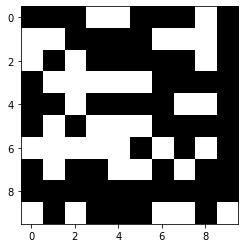

In [6]:
# Patterns
xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
xi[xi==0]=-1
idx = np.random.randint(0,p)
plt.imshow(xi[idx].reshape(10,10),cmap='Greys') # This is an example of pattern 

In [7]:
# Coupling constant
# Row i is the connections of the i-th neuron with the others.
# Note that the hopfield model requires Jii=0
# Note that J is a symmetrical matrix (J=J.T)
J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
J = J.reshape(N,N)
for i in range(len(J)):
    J[i,i] = 0
J==J.T

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [8]:
# Update rule
def update(sys):
    N = len(sys)
    for i in range(N):
        temp = 0
        for j in range(N):
            temp +=  J[i][j]*sys[j] 
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys, t):
    for i in range(t):
        sys = update(sys)
    return sys

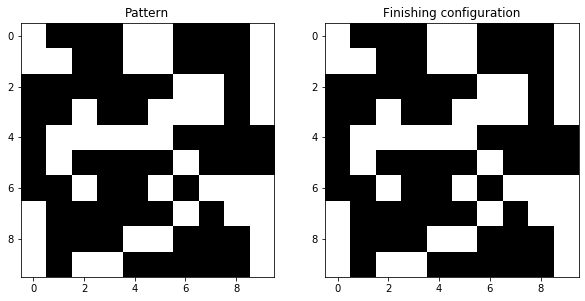

In [9]:
# actual algorithm
from copy import deepcopy
idx = np.random.randint(0,p)
sys = deepcopy(xi[idx])

sys = deterministic_hopfield(sys,30)

fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')

In [16]:
# Computing the stabilty of the algorithm
def score(xi, t):
    score = 0
    p = len(xi)
    for i in range(p):
        sys = deepcopy(xi[i])
        sys = deterministic_hopfield(sys,t)
        if np.all( [ sys, xi[i] ] ): score += 1
    return score/p

In [22]:
# We now look at the scaling with regards to the parameters
L = np.array([16])#,16,22,28])
N = L**2 
scores = []
for n in N:
    P = np.arange(5,n/2,20)
    for p in P: 
        p = int(p)
        xi = np.random.randint(0,2,n*p).reshape(p,n) # Each line is a pattern
        xi[xi==0]=-1
        J = 1/n * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(n) for j in range(n) ] )
        J = J.reshape(n,n)
        for k in range(len(J)):
            J[k,k] = 0
        scores.append( score(xi,10) )

In [23]:
scores

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

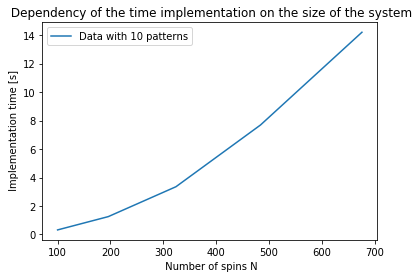

In [30]:
# How does the time scales with the number of spins N?
import time as time
L = np.arange(10,28,4)
N = L**2 
p = 10
times = []
for n in N:
    xi = np.random.randint(0,2,n*p).reshape(p,n)
    xi[xi==0]=-1
    J = 1/n * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(n) for j in range(n) ] )
    J = J.reshape(n,n)
    for k in range(len(J)):
        J[k,k] = 0
    idx = np.random.randint(0,p)
    start = time.time()
    deterministic_hopfield(xi[idx],30)
    end = time.time()
    times.append(end-start)

fig, ax = plt.subplots()
ax.plot(N,times, label = 'Data with 10 patterns')
ax.set_xlabel(' Number of spins N')
ax.set_ylabel(' Implementation time [s]')
ax.set_title(' Dependency of the time implementation on the size of the system')
ax.legend()

help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck
help!
fuck


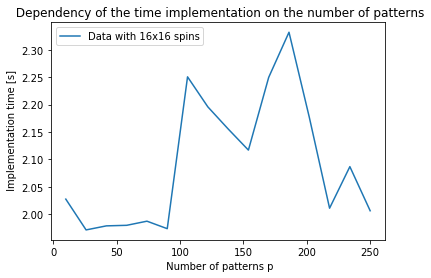

In [36]:
# How does the time scales with the number of pattern p with a fixed N?
import time as time
L = 16
N = L**2 
P = np.arange(10,N,16)
times = []
for p in P:
    p = int(p)
    xi = np.random.randint(0,2,N*p).reshape(p,N)
    xi[xi==0]=-1
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)
    for k in range(len(J)):
        J[k,k] = 0
    idx = np.random.randint(0,p)
    start = time.time()
    deterministic_hopfield(xi[idx],30)
    end = time.time()
    times.append(end-start)

fig, ax = plt.subplots()
ax.plot(P,times, label = 'Data with 16x16 spins')
ax.set_xlabel(' Number of patterns p')
ax.set_ylabel(' Implementation time [s]')
ax.set_title(' Dependency of the time implementation on the number of patterns')
ax.legend()